In [39]:
DATA_DIR = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/data/'
GRAPH_PATH = '/home/nsuprotivniy/Documents/Работа/OKru/Antispam/graph/'
SAMPLE_SIZE = 10000 # -1 если использовать все даннные
DEPTH_RANGE = range(1, 20, 2)
KNN_NEIGHBORS_RANGE = range(1, 20, 2)

In [2]:
!pip install pyarrow
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import user_agents
%matplotlib inline
from matplotlib import pyplot as plt
pd.set_option("display.precision", 2)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [40]:
http = pq.read_table(DATA_DIR + 'botsHTTPRequests-20180217_1718_parsedUA.parquet').to_pandas().head(SAMPLE_SIZE)

In [41]:
def encode(col):
    le = LabelEncoder()
    le.fit(col)
    return le.transform(col)
    
X = http[[
    'userAgentIsBot',
    'userAgentIsMobile',
    'userAgentIsTablet',
    'userAgentIsTouchCapable',
    'userAgentIsPC',
    'userAgentOSFamily',
    'userAgentOSVersion0',
    'userAgentOSVersion1',
    'userAgentOSVersion2',
    'userAgentBrowserFamily',
    'userAgentBrowserVersion0',
    'userAgentBrowserVersion1',
    'userAgentBrowserVersion2',
    'userAgentDeviceFamily',
    'userAgentDeviceBrand',
    'userAgentDeviceModel',
    'from',
    'to',
    'url',
    'requestType',
    'operation'
]].apply(encode, axis=0)

y = http['isBot']

In [5]:
rows, feats = X.shape

In [6]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

tree = DecisionTreeClassifier(random_state=17)
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)

In [7]:
tree_params = {'max_depth': DEPTH_RANGE,'max_features': range(1, feats)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True, scoring='f1')
tree_grid.fit(X_train, y_train)
tree_grid.best_params_, tree_grid.best_score_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nsuprotivniy/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.7s finished


({'max_depth': 13, 'max_features': 20}, 0.901182746178342)

In [8]:
f1_score(y_holdout, tree_grid.predict(X_holdout))

0.9029094475318732

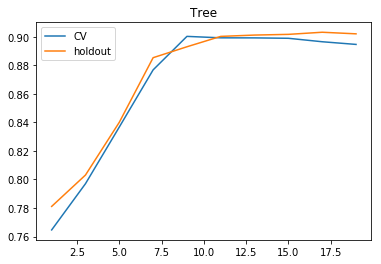

In [9]:
cv_scores, holdout_scores = [], []
max_depth = DEPTH_RANGE

for k in max_depth:

    tree = DecisionTreeClassifier(random_state=17, max_depth=k)
    cv_scores.append(np.mean(cross_val_score(tree, X_train, y_train, cv=5, scoring='f1')))
    tree.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, tree.predict(X_holdout)))

plt.plot(max_depth, cv_scores, label='CV')
plt.plot(max_depth, holdout_scores, label='holdout')
plt.title('Tree')
plt.savefig(GRAPH_PATH + 'tree.png', dpi=900)
plt.legend();

In [10]:
knn_params = {'knn__n_neighbors': KNN_NEIGHBORS_RANGE}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True, scoring='f1')
knn_grid.fit(X_train, y_train)
knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.7s finished


({'knn__n_neighbors': 3}, 0.8355518889847526)

In [11]:
f1_score(y_holdout, knn_grid.predict(X_holdout))

0.8412073490813649

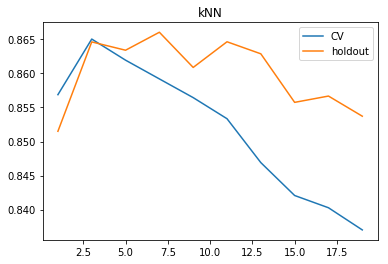

In [12]:
cv_scores, holdout_scores = [], []
n_neighb = KNN_NEIGHBORS_RANGE

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')))
    knn.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, knn.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('kNN')
plt.savefig(GRAPH_PATH + 'knn.png', dpi=900)
plt.legend();

In [13]:
forest_params = {'max_depth': DEPTH_RANGE,'max_features': range(1,feats)}
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True, scoring='f1')
forest_grid.fit(X_train, y_train)
forest_grid.best_params_, forest_grid.best_score_ 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.0min finished


({'max_depth': 19, 'max_features': 15}, 0.9100037427434079)

In [14]:
f1_score(y_holdout, forest_grid.predict(X_holdout))

0.9116584564860428

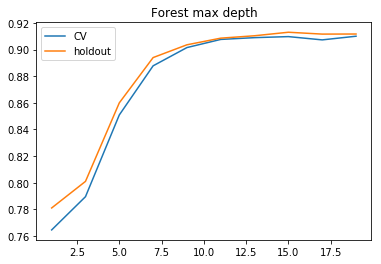

In [15]:
cv_scores, holdout_scores = [], []
max_depth = DEPTH_RANGE

for k  in max_depth:
    forest = RandomForestClassifier(n_estimators=100, 
                                max_depth = k,
                                max_features = forest_grid.best_params_['max_features'],
                                n_jobs=-1, 
                                random_state=17)
    cv_scores.append(np.mean(cross_val_score(forest, X_train, y_train, cv=5, scoring='f1')))
    forest.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, forest.predict(X_holdout)))

plt.plot(max_depth, cv_scores, label='CV')
plt.plot(max_depth, holdout_scores, label='holdout')
plt.title('Forest max depth')
plt.savefig(GRAPH_PATH + 'forest_maxdepth.png', dpi=900)
plt.legend();

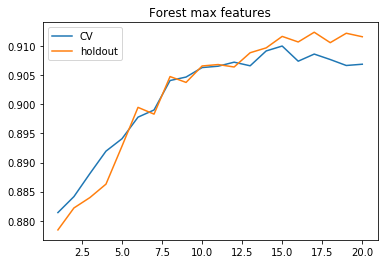

In [16]:
cv_scores, holdout_scores = [], []
max_features = range(1, feats)

for k  in max_features:
    forest = RandomForestClassifier(n_estimators=100, 
                                    max_depth = forest_grid.best_params_['max_depth'],  
                                    max_features = k,
                                    n_jobs=-1, 
                                    random_state=17)
    cv_scores.append(np.mean(cross_val_score(forest, X_train, y_train, cv=5, scoring='f1')))
    forest.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, forest.predict(X_holdout)))

plt.plot(max_features, cv_scores, label='CV')
plt.plot(max_features, holdout_scores, label='holdout')
plt.title('Forest max features')
plt.savefig(GRAPH_PATH + 'forest_maxfeats.png', dpi=900)
plt.legend();

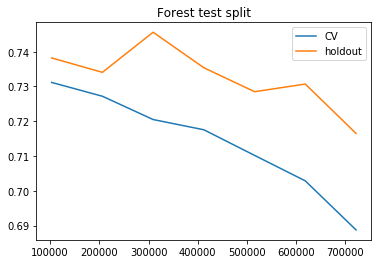

In [38]:
cv_scores, holdout_scores = [], []
split = np.arange(0.1, 0.8, 0.1)

for i in split:
    X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=i, random_state=17)
    forest = RandomForestClassifier(n_estimators=5, 
                                    max_depth = 19,  
                                    max_features = 15,
                                    n_jobs=-1, 
                                    random_state=17)
    cv_scores.append(np.mean(cross_val_score(forest, X_train, y_train, cv=2, scoring='f1')))
    forest.fit(X_train, y_train)
    holdout_scores.append(f1_score(y_holdout, forest.predict(X_holdout)))

plt.plot(split * X.shape[0], cv_scores, label='CV')
plt.plot(split * X.shape[0], holdout_scores, label='holdout')
plt.title('Forest test split')
plt.savefig(GRAPH_PATH + 'forest_testsplit_2.png', dpi=900)
plt.legend();